# Άσκηση 2.9(γ): Iterative Reweighted Least Squares

Σε πρώτο στάδιο, θα υλοποιήσουμε τον αλγόριθμο iterative reweighted least squares (IWLS) για multiclass logistic regression.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

Αρχικά, διαβάζουμε τα δεδομένα εισόδου που αποτελούνται από διανύσματα δύο διαστάσεων, x1 και x2, τα οποία κατηγοριοποιούνται σε τρεις κλάσεις: 0, 1 και 2. Στα διανύσματα εισόδου Χ προσαυξάνουμε την διάσταση κατά ένα, ώστε x[0] = 1, προκειμένου να διευκολυνθούμε στις πράξεις με το bias των decision surfaces.

Επιπλέον, ορίζουμε:
- $Ν$: τον αριθμό των δειγμάτων εισόδου. Στην προκειμένη περίπτωση, έχουμε 120 δείγματα.
- $Μ$: τον αριθμό των χαρακτηριστικών κάθε δείγματος. Στην προκειμένη περίπτωση, έχουμε 3 χαρακτηριστικά, με το πρώτο να είναι πάντα μονάδα για το bias.
-$K$: τον αριθμό των κλάσεων του προβλήματος, στην προκειμένη περίπτωση 3.

In [ ]:
# Read Data
f = open('MLR.data',"r")
lines = f.readlines() 
x1 = []
x2 = []
y = []
for x in lines:
    x1.append(float(x.split(' ')[0]))
    x2.append(float(x.split(' ')[1]))
    y.append(int(x.split(' ')[2][0]))
f.close()

In [ ]:
X = np.column_stack((np.ones(len(x1)),x1,x2)) # concatenate 1 for bias multiplication
y = np.array(y)
print(X.shape)
N, M = X.shape
K = len(np.unique(y)) # 3 classes

(120, 3)


Έπειτα, για να ορίσουμε τις a-posteriori πιθανότητες του Multiclass Logistic Regression Classifier, χρησιμοποιούμε τη συνάρτηση softmax:
$$p(C_k|φ_n) = y_{nk}(φ_n) = \frac{exp^{w_k^Tφ_n}}{\sum_{j=1}^{K}exp^{w_j^Tφ_n}}$$

όπου $φ_n$: η συνάρτηση βάσης πάνω στo δείγμα $Χ_n$.

In [ ]:
def softmax(x, w, Class):
  numerator = np.exp(np.dot(w[Class,:], x))
  denominator = 0.
  for i in range(np.shape(w)[0]):
    denominator += np.exp(np.dot(w[i,:], x))
  return numerator/denominator

In [ ]:
def softmax_all(X, w, K = 3):
  N = X.shape[0]
  Y = np.zeros((N,K)) # samples x classes = N x K
  for j in range(K):
      for n in range(N):
        Y[n,j] = softmax(X[n], w, Class = j)
  return Y

In [ ]:
w = np.random.rand(K, M) # weight vectors KxM - one for each class

Έπειτα, χρησιμοποιούμε ένα 1-of-K coding scheme, με βάση το οποίο το target vector $t_n$ για ένα διάνυσμα χαρακτηριστικών $φ_n$ το οποίο ανήκει στην κλάση
$C_k$ είναι ένα δυαδικό διάνυσμα με μηδέν όλα τα στοιχείο του, εκτός του k-οστού στοιχείου που είναι μονάδα.

In [ ]:
# One-Hot Encode Labels
enc = OneHotEncoder()
enc.fit(np.array(y).reshape(len(y), 1))
T = enc.transform(np.array(y).reshape(len(y), 1)).toarray() # T: y one-hot encoded N x K

Ακολούθως, ορίζουμε τη συνάρτηση σφάλματος που λειτουργεί ως μετρική της επίδοσης του Logistic Regression Classifier. Η εν λόγω συνάρτηση $E(w)$, γνωστή και ως cross-entropy, είναι στην ουσία των log-likelihood των δειγμάτων εισόδου και ορίζεται ως:
$$E(w_1, ..., w_K) = -lnp(T|w_1, ..., w_K) = -\sum_{n=1}^{N} \sum_{k=1}^{K}t_{nk}lny_{nk}$$

In [ ]:
# Log-Likelihood Error Function
def log_likelihood(x, y_enc, w, classes = 3):
  E = 0

  for n in range(x.shape[0]):
    for k in range(classes):
      ynk = softmax(x[n], w, Class = k)
      E -= y_enc[n,k]*np.log(ynk)
  
  return E

In [ ]:
w = np.random.rand(K, M)
print('Random Weights: Log-Likelihood E = ', log_likelihood(X, T, w))

Random Weights: Log-Likelihood E =  127.04051855009493


Για την εκτέλεση του IRLS αλγορίθμου, ωστόσο, χρειαζόμαστε την **Hessian μήτρα** της συνάρτησης σφάλματος Ε. Η μήτρα αυτή είναι διαστάσεων $KM * KM$ και αποτελείται από επαναλαμβανόμενα μπλοκ διαστάσεων $M * M$, με το μπλοκ j,k να δίνεται ως:
$$ \nabla_{w_k}\nabla_{w_j}E(w) = \sum_{n=1}^{N}y_{nk}(I_{kj}-y_{nj})φ_nφ_n^T = Φ^ΤRΦ$$

$R$: διαγώνιος πίνακας με στοιχεία $y_{nk}(I_{kj}-y_{nj})$ \\
$Ι$: ο μοναδιαίος πίνακας

In [ ]:
def Hessian(X, w, K = 3):
  N, M = X.shape
  H = np.zeros((K*M,K*M))
  I = np.eye(K)
  Y = softmax_all(X, w)
  for k in range(K):
    for j in range(K):
        # Diagonal R
        R = np.zeros((N,N)) 
        for n in range(N):
            R[n][n] = Y[n][k] * (I[k,j] - Y[n][j])

        H[k*M:k*M+M, j*M:j*M+M] = np.dot( np.dot(X.T, R), X )
  
  return H # KM x KM

Ομοίως, προσδιορίζουμε και την πρώτη παράγωγο της συνάρτησης Ε ως:
$$\nabla_{w_j} E(w) = \sum_{n=1}^{N}(y_{nj} - t_{nj})φ_n$$

In [ ]:
def GradientE(X, w, K = 3):
  N, M = X.shape
  grad_E = np.zeros((K,M)) # K x M
  for j in range(K):
    for n in range(N):
      ynj = softmax(X[n],w, Class = j)
      grad_E[j,:] += (ynj - T[n,j])*X[n]
  
  return grad_E

Στο σημείο αυτό, τρέχουμε τον αλγόριθμο IRLS για Multiclass LR. Ο αλγόριθμος τρέχει επαναληπτικά (εδώ για 20 επαναλήψεις), και τα βάρη ανανεώνονται ως εξής:
$$w^{new} = w^{old} - H^{-1}\nabla_w E $$
$$🠦w^{new} = w^{old} - (Φ^ΤRΦ)^{-1}Φ^Τ(y-t) $$

In [ ]:
# IRLS Algorithm
w = np.ones((K, M)) # initialize with ones
total_error = [] # Log-Likelihood Function

for iteration in range(20):
  gradE = GradientE(X, w) # K, M
  H = Hessian(X, w) # KM x KM

  # Newton-Raphson update
  w = np.reshape(w,(K*M,1))
  gradE = np.reshape(gradE, (K*M,1))
  w -= np.dot(np.linalg.pinv(H), gradE)
  w = np.reshape(w, (K,M))

  total_error.append(log_likelihood(X,T,w)) # collect loss

In [ ]:
print('Weights After 20 Iterations of IRLS:')
print(w)

Weights After 20 Iterations of IRLS:
[[ -0.55576221  -6.52705988   2.66298619]
 [-12.35573972   1.31499084  -4.16030782]
 [ 15.04372858  -4.48760453  -8.97792324]]


In [ ]:
print('Cross-Entropy Error after 20 Iterations of IRLS:', log_likelihood(X,T,w))

Cross-Entropy Error after 20 Iterations of IRLS: 2.864611554360134e-07


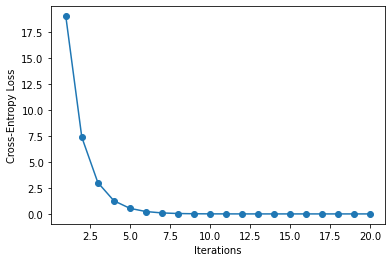

In [ ]:
plt.plot([i for i in range(1,21)], total_error, '-o')
plt.xlabel('Iterations')
plt.ylabel('Cross-Entropy Loss')
plt.show()

Ακολούθως, βλέπουμε τις επιφάνειες διαχωρισμού που χωρίζουν τα δείγματα στις τρεις κατηγορίες, με βάση τις ανανεωμένες τιμές των βαρών w μετά από 20 επαναλήψεις του IRLS αλγορίθμου.

In [ ]:
# Function that predicts output class, given weights w
def predict(X, w):
  return np.argmax(softmax_all(X,w), axis = 1)

In [ ]:
# Function to plot decision Surfaces (from python helper lab)
def plot_clf(w, X, y, labels, clf = 'IRLS'):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of LR Classifier')
    # Set-up grid for plotting.
    X0, X1, X2 = X[:,0], X[:,1], X[:,2]
    
    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                         np.arange(y_min, y_max, .05))
    
    if clf == 'IRLS': 
      Z = predict(np.column_stack((np.ones(len(xx.ravel())), np.c_[xx.ravel(), yy.ravel()])), w)
    else:
      Z = np.argmax(np.dot(np.column_stack((np.ones(len(xx.ravel())), np.c_[xx.ravel(), yy.ravel()])),w), axis=1)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    zeros = ax.scatter(
        X1[y == 0], X2[y == 0],
        c='blue', label=labels[0],
        s=60, alpha=0.9, edgecolors='k')
    ones = ax.scatter(
        X1[y == 1], X2[y == 1],
        c='red', label=labels[1], 
        s=60, alpha=0.9, edgecolors='k')
    twos = ax.scatter(
        X1[y == 2], X2[y == 2],
        c='green', label=labels[2],
        s=60, alpha=0.9, edgecolors='k')
    
    ax.set_ylabel('X2')
    ax.set_xlabel('X1')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

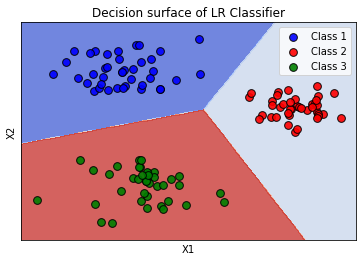

In [ ]:
plot_clf(w, X, y, labels=['Class 1', 'Class 2', 'Class 3'])

Παρατηρεί κανείς ότι οι τελικές ευθείες που ορίζουν τα βάρη w χωρίζουν τέλεια τα δείγματα εισόδου στις τρεις κλάσεις. Η επιτυχία αυτή μπορεί να ποσοτικοποιηθεί και με βάση την μετρική accuracy:

In [ ]:
def score(X, w, y):
  y_pred = predict(X,w)
  acc = accuracy_score(y_pred, y)
  return acc

accuracy = score(X,w,y)
print('IRLS Logistic Regression Accuracy = '+str(100*accuracy)+'%')

IRLS Logistic Regression Accuracy = 100.0%


Παρατηρούμε ότι έχουμε ποσοστό ευστοχίας 100%.

## Linear Regression with Sum-of-Squares Loss Function

Στο πρόβλημα γραμμικής πρόβλεψης με συνάρτηση κόστους την Sum-of-Squares ο Newton-Raphson τύπος ανανέωσης βαρών παίρνει σε μόλις ένα βήμα την μορφή:
$$w^{new} = (Φ^ΤΦ)^{-1}Φ^Τt$$
την οποία αναγνωρίζουμε ως τη κλασική λύση ελαχίστων τετραγώνων.

In [ ]:
pseudo_inv = np.linalg.pinv(X)
w_lin = np.dot(pseudo_inv,T)
print('Weights of Linear Regression with S.o.S Function:')
print(w_lin)

Weights of Linear Regression with S.o.S Function:
[[ 0.30015285  0.12967629  0.57017086]
 [-0.05663662  0.08432925 -0.02769264]
 [ 0.12494785  0.01922407 -0.14417192]]


Παρουσιάζουμε στον χώρο τις τρεις ευθείες διαχωρισμού για τα άνωθι βάρη, καθώς και το ποσοστό ευστοχίας του ταξινομητή και την τιμή της συνάρτησης σφάλματος cross-entropy.

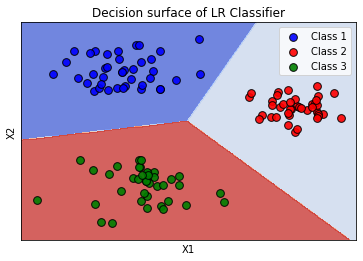

In [ ]:
plot_clf(w_lin, X, y, labels=['Class 1', 'Class 2', 'Class 3'], clf='Linear Regression')

In [ ]:
y_pred = np.argmax(np.dot(X, w_lin), axis=1)
acc2 = accuracy_score(y_pred, y)
print('Accuracy =',str(100*acc2),'%')

Accuracy = 100.0 %


Παρατηρούμε ότι η λύση της linear regression με συνάρτηση κόστους την Sum of Squares δίνει εξίσου ικανοποιητικά αποτελέσματα με τον αλγόριθμο IRLS (Accuracy = 100%). Οι ευθείες διαχωρισμού καταφέρνουν να χωρίσουν τα δείγματα στις 3 κλάσεις πλήρως.